In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [23]:
def load_f1_data():
    """Load and clean F1 pitstop data"""
    try:
        df = pd.read_csv('f1_pitstops_2018_2024.csv')
        print(f"Loaded {df.shape[0]} rows")
        
        # Clean data
        df = df.dropna(subset=['Driver', 'AvgPitStopTime', 'Position']).drop_duplicates()
        
        print(f"Cleaned dataset: {df.shape[0]} rows")
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        return None

# Execute
f1_data = load_f1_data()

if f1_data is not None:
    print("\nData sample:")
    print(f1_data.head())

Loaded 7374 rows
Cleaned dataset: 7189 rows

Data sample:
   Season  Round                         Circuit                Driver  \
0    2018      1  Albert Park Grand Prix Circuit      Sebastian Vettel   
1    2018      1  Albert Park Grand Prix Circuit      Sebastian Vettel   
2    2018      1  Albert Park Grand Prix Circuit        Lewis Hamilton   
3    2018      1  Albert Park Grand Prix Circuit        Lewis Hamilton   
4    2018      1  Albert Park Grand Prix Circuit  Kimi RÃƒÂ¤ikkÃƒÂ¶nen   

  Constructor  Laps  Position  TotalPitStops  AvgPitStopTime  \
0     Ferrari    58         1              1          21.787   
1     Ferrari    58         1              1          21.787   
2    Mercedes    58         2              1          21.821   
3    Mercedes    58         2              1          21.821   
4     Ferrari    58         3              1          21.421   

               Race Name  ... Tire Usage Aggression Fast Lap Attempts  \
0  Australian Grand Prix  ...          

In [37]:
def create_champion_features(df):
    """Create driver-level features for champion prediction"""
    
    # Aggregate to driver level
    driver_stats = df.groupby('Driver').agg({
        'AvgPitStopTime': 'mean',
        'Position': ['mean', 'min'],  # Average and best finish
        'Laps': 'count'               # Experience
    }).round(3)
    
    driver_stats.columns = ['avg_pit_time', 'avg_position', 'best_position', 'races_count']
    
    # Key performance indicators
    driver_stats['pit_efficiency'] = 1 / driver_stats['avg_pit_time']
    driver_stats['podiums'] = (driver_stats['best_position'] <= 3).astype(int)
    
    return driver_stats

# Load data
f1_data = load_f1_data()

# Create champion prediction features AND DISPLAY THEM
if f1_data is not None:
    driver_features = create_champion_features(f1_data)
    
    print("🚀 DRIVER FEATURES FOR CHAMPION PREDICTION:")
    print("=" * 60)
    print(f"📊 Features for {len(driver_features)} drivers:")
    print(driver_features)
    
    print("\n📈 Top 10 drivers by pit efficiency:")
    print(driver_features.nlargest(10, 'pit_efficiency'))
    
    print("\n🏆 Top 10 drivers by best position:")
    print(driver_features.nsmallest(10, 'best_position'))
else:
    print("❌ No data to process")

Loaded 7374 rows
Cleaned dataset: 7189 rows
🚀 DRIVER FEATURES FOR CHAMPION PREDICTION:
📊 Features for 40 drivers:
                      avg_pit_time  avg_position  best_position  races_count  \
Driver                                                                         
Alexander Albon             91.363        11.337              3          267   
Antonio Giovinazzi         132.300        13.669              9          148   
Brendon Hartley             24.689        14.108              9           37   
Carlos Sainz               135.292         7.038              1          342   
Charles Leclerc            109.699         6.885              1          358   
Daniel Ricciardo           134.697        10.402              1          291   
Daniil Kvyat                98.244        10.844              3           96   
Esteban Ocon               130.330        10.568              1          278   
Fernando Alonso            151.068         9.182              2          269   
Franco

Loaded 7374 rows
Cleaned dataset: 7189 rows

Driver-level features for champion prediction:
                     avg_pit_time  avg_position  best_position  races_count  \
Driver                                                                       
Alexander Albon           91.363        11.337              3          267   
Antonio Giovinazzi       132.300        13.669              9          148   
Brendon Hartley           24.689        14.108              9           37   
Carlos Sainz             135.292         7.038              1          342   
Charles Leclerc          109.699         6.885              1          358   

                    pit_efficiency  podiums  
Driver                                       
Alexander Albon           0.010945        1  
Antonio Giovinazzi        0.007559        0  
Brendon Hartley           0.040504        0  
Carlos Sainz              0.007391        1  
Charles Leclerc           0.009116        1  


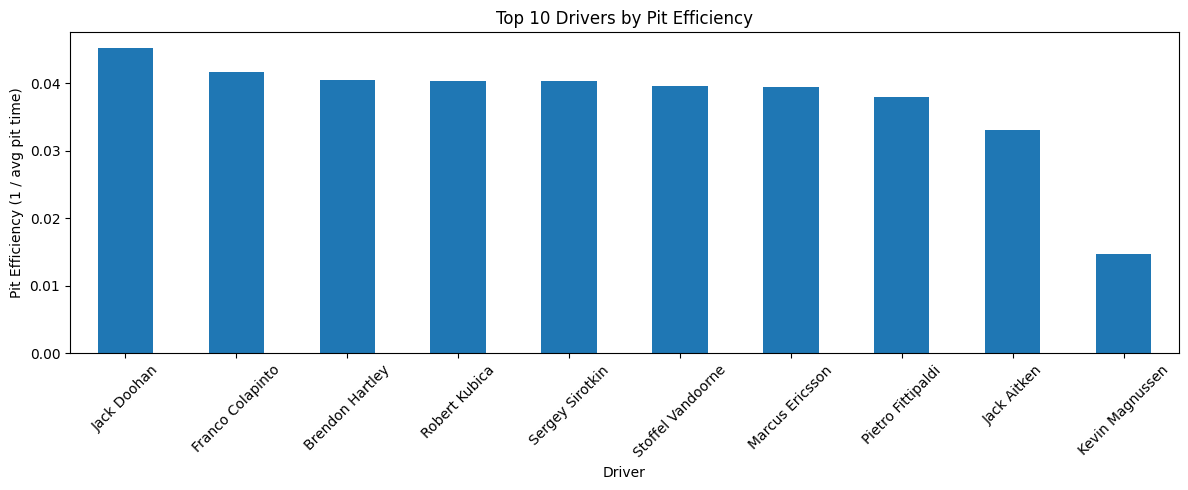

Logistic Regression: Accuracy = 1.000, F1 Score = 1.000
Random Forest: Accuracy = 1.000, F1 Score = 1.000
K-Nearest Neighbors: Accuracy = 0.875, F1 Score = 0.800

Best model selected: Logistic Regression


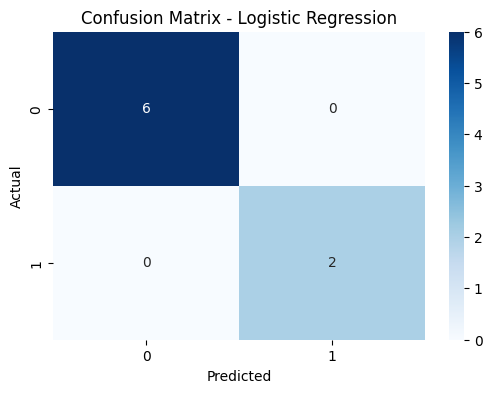


2025 F1 Champion Predictions (Top 5):
1. Jack Doohan - Probability: 98.2% (Best position: 15.0)
2. Robert Kubica - Probability: 97.9% (Best position: 10.0)
3. Pietro Fittipaldi - Probability: 97.9% (Best position: 17.0)
4. Sergey Sirotkin - Probability: 97.1% (Best position: 10.0)
5. Brendon Hartley - Probability: 96.7% (Best position: 9.0)


In [38]:
def plot_driver_features(df):
    plt.figure(figsize=(12, 5))
    df.sort_values('pit_efficiency', ascending=False)['pit_efficiency'].head(10).plot(kind='bar')
    plt.title('Top 10 Drivers by Pit Efficiency')
    plt.ylabel('Pit Efficiency (1 / avg pit time)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def train_and_evaluate(X, y):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=500),
        'Random Forest': RandomForestClassifier(random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier()
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results[name] = {'model': model, 'accuracy': accuracy, 'f1_score': f1}

        print(f"{name}: Accuracy = {accuracy:.3f}, F1 Score = {f1:.3f}")

    # Choose best model by accuracy
    best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    print(f"\nBest model selected: {best_name}")

    # Confusion matrix for best model
    best_model = results[best_name]['model']
    y_pred_best = best_model.predict(X_test_scaled)

    plt.figure(figsize=(6,4))
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {best_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return best_model, scaler, X_test_scaled, y_test

def predict_champions(model, scaler, df):
    # Use driver features for prediction
    X = df[['avg_pit_time', 'avg_position', 'pit_efficiency']]
    X_scaled = scaler.transform(X)
    proba = model.predict_proba(X_scaled)[:, 1]

    df['champion_probability'] = proba
    df_sorted = df.sort_values('champion_probability', ascending=False)

    print("\n2025 F1 Champion Predictions (Top 5):")
    for i, (driver, row) in enumerate(df_sorted.iterrows()):
        print(f"{i+1}. {driver} - Probability: {row['champion_probability']:.1%} (Best position: {row['best_position']})")
        if i >= 4:
            break

    return df_sorted

def main():
    # Load original race data function (assumed predefined)
    df = load_f1_data()

    if df is None or df.empty:
        print("No data loaded, exiting.")
        return

    # Create driver features
    driver_df = create_champion_features(df)
    print("\nDriver-level features for champion prediction:\n", driver_df.head())

    # Plot feature
    plot_driver_features(driver_df)

    # Create binary target: drivers with pit efficiency in top 30% are potential champions
    threshold = driver_df['pit_efficiency'].quantile(0.7)
    driver_df['potential_champion'] = (driver_df['pit_efficiency'] >= threshold).astype(int)

    X = driver_df[['avg_pit_time', 'avg_position', 'pit_efficiency']]
    y = driver_df['potential_champion']

    best_model, scaler, X_test_scaled, y_test = train_and_evaluate(X, y)

    predictions = predict_champions(best_model, scaler, driver_df)

    return predictions

if __name__ == "__main__":
    predict_champions = main()